***READ PICKLED PREPROCESSED DATAFRAME***

In [1]:
import pandas as pd

df = pd.read_pickle('df.pkl')

***OR READ AND PROCESS FROM SCRATCH***

In [19]:
import pandas as pd

syn2019 = pd.read_csv('Data/GOUT-CC-2019-CORPUS-SYNTHETIC.csv')
syn2020 = pd.read_csv('Data/GOUT-CC-2020-CORPUS-SYNTHETIC.csv')

In [20]:
df = pd.concat([syn2019, syn2020], axis=0).reset_index(drop=True)

In [21]:
df = df[(df.Consensus != '-') | (df.Predict != '-')]
print(df.shape)

(8435, 3)


In [22]:
df = df.drop(columns=['Predict'])
df = df.rename(columns={'Chief Complaint': 'corpus', 'Consensus': 'target'})

In [23]:
import re
import string

def clean_text(text):
    text=text.lower()                                                 # change all chars to lowercase    
    text=re.sub('[%s]' % re.escape(string.punctuation), '', text)     # remove punctuations
    text=re.sub("(\\d|\\W)+"," ",text)                                # remove numbers
    return text


df['corpus'] = df['corpus'].apply(lambda x:clean_text(x))

***ADD stop words to list***

In [24]:
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
print(len(STOP_WORDS))

350


In [25]:
STOP_WORDS |= {'co', 'denies', 'htn', 'hx','pt','pmh', 'pmhx', 'states','days', 'ago', 'reports',
              'week', 'weeks', 'today', 'yesterday', 'seen', 'sent', 'started', 'day', 'like',
              'morning', 'having','x', 'X'}

In [26]:
print(len(STOP_WORDS))

350


***Create Test-Train Split for Vectorization***

In [27]:
predict = df.target
print(predict.value_counts())

-    7974
N     350
Y      95
U      16
Name: target, dtype: int64


In [28]:
print(df)

                                                 corpus target
0     been feeling bad last weeks switched bp medica...      -
1     cant walk reports onset at am oriented x aorti...      N
2     dehydration chest hurts hips hurt cramps pmh h...      Y
3     gout flare up l arm swelling x week denies any...      Y
4     heart racingdyspnea and orthopnea that has bee...      -
...                                                 ...    ...
8432  stepped on a nail at home with right foot pain...      N
8433   i was having a breakdown rt stress and depres...      -
8434  i tried to jump in front of a car pt states sh...      -
8435                   abdominal pain x week denies pmh      -
8436  rashsores across body infection ro left thumb ...      N

[8435 rows x 2 columns]


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['corpus'], predict, test_size=0.33, random_state=55)
print(X_train)

5767    per ems family called bc pt was fighting and s...
7618    seen at mshgpc weeks ago and found mass in lef...
5004    ams per daughter was found in bathoom floor by...
1923    left arm weak since pt has left sided defecits...
3832               left testicle pain x hrs pmh migraines
                              ...                        
2595    started tx for h pylori yesterday now co nv an...
5488    possible allergic reaction ate crab legs crawf...
6198    r sided throbbing chest pain x days pt also co...
968               black stoolx months abd pain pmh denies
4762              lower back pain and pelvic pain x month
Name: corpus, Length: 5651, dtype: object


In [32]:
print([y_train == 'Y']==True)

False


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words=STOP_WORDS)
vectorized = vectorizer.fit_transform(X_train, y_train)
X_test_v = vectorizer.transform(X_test)
X_train_v = vectorizer.transform(X_train)

/opt/anaconda3/envs/mimicnlp/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


***Naive Bayes & Logistic Regression Models tested with CountVectorization Matrix***

***Multinomial Model***

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb = MultinomialNB()
nb.fit(X_train_v, y_train)
y_pred_class = nb.predict(X_test_v)
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy:', accuracy)

accuracy: 0.9382183908045977


***Logistic Regression Model***

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


logreg = LogisticRegression()
logreg.fit(X_train_v, y_train)
y_pred_prob = logreg.predict_proba(X_test_v)[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

ValueError: multi_class must be in ('ovo', 'ovr')

***Naive Bayes & Logistic Regression Models tested with Tf-idf Matrix***

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words=STOP_WORDS)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

/opt/anaconda3/envs/mimicnlp/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


**Naive Bayes Model usig Tf-idf***

In [37]:
# Create the list of alphas
alphas = [0,.01, .1, .5, .8, 1]

# Define train_and_predict()
def train_and_predict(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

# Test several settings for alpha
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0
Score:  0.9400143678160919

Alpha:  0.01
Score:  0.9410919540229885

Alpha:  0.1
Score:  0.9392959770114943

Alpha:  0.5
Score:  0.9389367816091954

Alpha:  0.8
Score:  0.9389367816091954

Alpha:  1
Score:  0.9389367816091954



/opt/anaconda3/envs/mimicnlp/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [38]:
nb_classifier = MultinomialNB(alpha=0)
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.9400143678160919


/opt/anaconda3/envs/mimicnlp/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [39]:
# Plots confusion matrix of model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plots confusion matrix of model

def plot_confusion(y_test, pred):
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true')
    plt.ylabel('predicted')

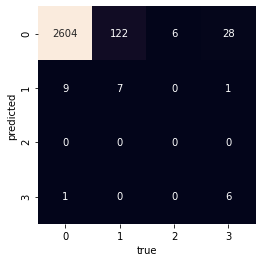

In [40]:
plot_confusion(y_test, pred)
plt.show()

***Tune NB model***  As seen below the best performance is with alpha set to 0